## Purpose: An quote to order model that will generalize to inputs beyond range of dataset.  
### A closed order is a quote that results in an order within 90 days from the quote date. 

### This model is designed to work with sparse data and high granularity.  In this case, granulaty is from many part numbers in combination with many customers with intermittent purchases.  No complete time sequences exist due to the granularity.  It can be applied to retail and distribution models as well as demand planning systems.

## Build Quote to Order Probability ('Win') Predictor 

### Libraries and Utilities

In [1]:
%reload_ext autoreload
%autoreload

In [2]:
!mkdir win_checkpoint
!mkdir win_all_checkpoint
!mkdir win_all_model
!mkdir win_maps
!mkdir win_val_model

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
#allow cell to perform multiple computations

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [5]:
#set cell width as percentage of window

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [6]:
from tensorflow.keras.backend import clear_session
clear_session()

In [7]:
# Python libraries needed

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn_pandas import DataFrameMapper 
import os as os
import string
from joblib import dump, load
import time
import gc

### Load Data

In [8]:
# Import Data
dx = load('Quote_Order_Data')

# Definitions:
#   'quote_num' is a unique number assigned to every quote; more than one item can be included on a quote number
#   'part' is the part name being quoted
#   'div' is the company division for a geographical territory and who manufactures the part
#   'dist_num' is a unique number assigned to the company distributors
#   'so_name' is the sales office name requesting the quote
#   'quote_qty' is the requested quote amount
#   'sales_qty' is the quantity shipped on the 'ship_date'; there can be multiple shipments against a quote
#   'quote_price' is the price first quoted; shipping prices can vary from competitive requirements
#   'ship_date' are the dates of shipment
#   'quote_date' is the date of the quote
#   'Win' is whether or note quote closed: 1 = closed, 0 = lost
#   'Quote_Yr' is year of quote issue
#   'Quote_Mon' is month of year quote issued
#   'Quote_Qtr' is quarter of year quote issued
#   'Close_Date' is date quote expires 1 year after first shipment
#   'Months_Used' is number of months passed in year to the quote closing date 

## Build Order Closed To Win Predictor
#### Encode, scale and shape data for tensorflow
#### Perform train test split

In [9]:
# Choose categorical feature vars
cat_vars = ['part', 'plant', 'dist', 'region']

# Choose time features vars
time_vars = ['Quote_Yr', 'Quote_Mon', 'Quote_Qtr']

# Choose continuous feature vars
cont_vars = ['quote_qty', 'quote_pr']

# Choose continuous feature vars to be logged and then scaled
cont_vars_log = ['quote_qty']

# Choose target features
targets = ['Win']

# Identify data and target dataframes
features = cat_vars + time_vars + cont_vars
data = dx[cat_vars + time_vars + cont_vars]
target = dx[targets]

### Apply encoders, embeddings, max/min embeddings and scalers to feature data

### Apply logs to feature variables with excesssive range

In [10]:
#  Take log on continuous features to be logged to reduce range
def log_cont_data(data, cont_vars_log=cont_vars_log):
    
    # take logs of each variable to be logged identified
    for feat in cont_vars_log:
        data[feat] = data[feat].apply(lambda x: np.log(x).astype(np.float32))
    
    # return data with logged columns
    return data

# insert logs into data
data = log_cont_data(data)

### Compute lists of embedding sizes as tuples of label encoders and scale continuous features

In [11]:
# Function to apply embeddings for categorical features in data

def cat_map_data(data,cat_vars=cat_vars, emax=50, emin=4):
    # compute list of number of unique categories for each categorical variable
    cat_emb = [len(data[c].unique()) for c in cat_vars]
    
    # compute list inserting maximum number of embeddings for each category 
    cat_emb_max = [c if c<= emax else emax for c in cat_emb] #maximum embedded weights is emax (default=50)
    
    # compute list inserting minimum number of embeddings for each category
    cat_emb_max = [c if c>= emin else emin for c in cat_emb_max] #minimum embedded weights is emin (default = 4)
    
    # form dictionary of the categorical variables and the list of embeddings
    cat_vars_dict = dict(zip(cat_vars,cat_emb_max))
    
    # form list of tuples of categorical variables and the label encoder
    cat_map = [(c,LabelEncoder()) for c in cat_vars]
    
    # return the embedding dictionary and the map of label encoders to categorical variables
    return cat_vars_dict,cat_map

In [12]:
# Function to apply embeddings for time features in data

def time_map_data(data,time_vars=time_vars, tmax=12, tmin=3):
    
    # compute number of unique values for each time variable
    time_emb = [len(data[t].unique()) for t in time_vars]
    
    # insert maximum embedded coefficients for time variables
    time_emb_max = [t if t <= tmax else tmax for t in time_emb] #maximum embedded weights is tmax (default=12)
    
    # insert minimum embedded coefficients for time variables
    time_emb_max = [t if t >= tmin else tmin for t in time_emb_max]#minimum embedded weights is tmin (default=3)
    time_vars_dict = dict(zip(time_vars,time_emb_max))
    
    # compute list of tuples assigning the Label Encoder to the time variable
    time_map = [(t,LabelEncoder()) for t in time_vars]
    
    # return dictionary of embedded coefficients and list of encoder tuples
    return time_vars_dict,time_map

In [13]:
# Function to apply scaler on the continuous features in data

# s can be standardscaler,robustscaler or minmaxscaler; default is minmax
# x,y is limit on minmax; default to 0,1
# l,u is percential rank for the robust scaler based on median; default is 10,90
# note that the minmax scaler will remove negative entrys resulting from log function

def cont_map_data(cont_vars=cont_vars, s='minmax', x=0, y=1, l=10, u=90): # s can be standardscaler,robustscaler or minmaxscaler
    
    # select scaler map and form list of tuples vor variable and scaler
    if s == 'standard':
        cont_map = [([c],StandardScaler(copy=True,with_mean=True,with_std=True)) for c in cont_vars]
    
    elif s == 'robust':
        cont_map = [([c],RobustScaler(with_centering=True,with_scaling=True,quantile_range=(t,u))) for c in cont_vars]
    
    elif s == 'minmax':
        cont_map = [([c],MinMaxScaler(feature_range = (x,y))) for c in cont_vars]
    
    # return map of scaler and continuous variables tuples
    return cont_map

### Transform feature variables and convert to array using DataFrameMapper

In [14]:
# Encode categorical features amd fit - transform with DataFrameMapper
def map_cat_data(data):
    
    # map encoder to categorical variables; cat_vars_dict required for input layers
    cat_vars_dict,cat_map = cat_map_data(data)
    
    # initialize dataframe mapper
    cat_mapper = DataFrameMapper(cat_map)
    
    # fit categorical variables; cat_map_fit required for input layer
    cat_map_fit = cat_mapper.fit(data)
    
    # transform data using dataframe mapper
    cat_data = cat_map_fit.transform(data).astype(np.int64) 
    
    # return cat_vars_dict and cat_map_fit used in embedding input layer to tensorflow
    return  cat_data, cat_vars_dict, cat_map_fit 

In [15]:
# Encode time features and fit - transform with DataFrameMapper    
def map_time_data(data):    
    
    # map encoder to time variables; time_vars_dict used in embedding input layer to tensorflow
    time_vars_dict,time_map = time_map_data(data)
    
    # initialize dataframemapper
    time_mapper = DataFrameMapper(time_map)
    
    # fit time variables to data; time_map_fit req'd for input layers
    time_map_fit = time_mapper.fit(data)
    
    # transform data
    time_data = time_map_fit.transform(data).astype(np.int64)
    
    # return encoded time data, time_vars_dict and time_map_fit used in input layer
    return time_data, time_vars_dict, time_map_fit 

In [16]:
# Scale continuous features and fit with DataFrameMapper
def map_cont_data(data):
    
    # map scaler to continuous data;  cont_map_data defaults to data, cont_vars and minmax scaler, x = 0,y = 1
    cont_map = cont_map_data() 
    
    # intialize DataFrameMapper with scalers to be applied
    cont_mapper = DataFrameMapper(cont_map)
    
    # fit mapper to data; cont_map_fit is required when building input layers
    cont_map_fit = cont_mapper.fit(data)
    
    # transform and return data
    cont_data = cont_map_fit.transform(data).astype(np.float32)
    
    return cont_data, cont_map_fit

### Encode binary target
#### Note that LabelEncoder will first order ascending numeric and then ascending alphabetical.  Consequently, the encoder will assign 0 to the lowest number and then sequence 1,2,3.. to the next higher numbers.  Check that the label encoder does not reverse the designed result.

In [17]:
# Function to encode and shape categorical target tensor
def map_cat_target(target):   
    #target is dataframe series of shape(-1,)    
    
    # map label array
    y = np.array(target).reshape(-1,1)
    encoder = LabelEncoder()
    y_mapped = encoder.fit_transform(y)
    
    # shape y array
    y_mapped = np.array(y_mapped).reshape(-1,1).astype(np.int64)#tensorflow requires int64 in array
    return y_mapped

### Compute transformed and shaped input data

In [18]:

# Save input layer functions; cat_vars_dict and cat_map_fit
# Map parts, division, sales_office, dist_num to encoded categories

# scale and encode data
data_cat, cat_vars_dict, cat_map_fit = map_cat_data(data)
data_time, time_vars_dict, time_map_fit = map_time_data(data)
data_cont, cont_map_fit = map_cont_data(data)

# concatenate scaled and encoded data
data_scaled = np.hstack([data_cat,data_time,data_cont])

# scale or encode target data
y_scaled = map_cat_target(target)

### Build maps of categorical and time features and save encoded labels for prediction scheme
### Scale and save scaler on continuous features for prediction scheme

In [19]:
# Function to map the encoding to the categories and save in win_maps subdirectory
# colname is in string format
def encode_cat(data,data_cat,colname):
    colnum = data.columns.get_loc(colname)
    label_map = dict(zip(data[colname],data_cat[:,colnum]))
    filename = os.path.join('win_maps',colname + '_cat_label_map')
    dump(label_map,filename)
    return colnum

# Function to map the encoding to time features and save in win_maps subdirectory
# colname is in string format
def encode_time(data,data_time,colname,catnum):
    colnum = data.columns.get_loc(colname)-(catnum + 1)
    label_map = dict(zip(data[colname],data_time[:,colnum]))
    filename = os.path.join('win_maps',colname + '_time_label_map')
    dump(label_map,filename)
    return

# Function to calculate scalers on continuous features and save in win_maps subdirectory
def scale_conts(data,colname,s):
     # select scaler
    if s == 'standard':
        scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
    elif s == 'robust':
        scaler = RobustScaler(with_centering=True,with_scaling=True,quantile_range=(10,90))
    elif s == 'minmax':
        scaler = MinMaxScaler(feature_range=(0,1))
    
    # fit scaler to column
    scaled = scaler.fit(np.array(data[colname]).reshape(-1,1))
    
    # save scaler to win_maps subdirectory   
    filename = os.path.join('win_maps',colname + '_cont_scaler')
    dump(scaled,filename)
    return
    

for colname in cat_vars:catnum=encode_cat(data,data_cat,colname)
for colname in time_vars:encode_time(data,data_time,colname,catnum)
for colname in cont_vars:scale_conts(data,colname,'minmax')


### Split data into train, validate and test sets.  Shape into list of arrays for tensorflow.

In [20]:
# Apply stratified split twice on win target for validation and test
# Note: splitting in tensorflow.keras.model.fit is not able to stratify by labels

# first stratify and split for test data on stratify target 'y-scaled'
data_,data_test,y_,y_test = train_test_split(data_scaled,y_scaled,test_size=.05,random_state=75,stratify=y_scaled)

# resize target vector for second stratification for validation data
temp = y_.reshape(-1,1)

# second stratify and split for validation data on resized target data
data_train,data_val,y_train,y_val = train_test_split(data_,y_,test_size=.20,random_state=75,stratify=temp)

# Convert train and test input data to list of arrays for tensorflow
X_train = np.hsplit(data_train, data_train.shape[1])
X_val = np.hsplit(data_val, data_val.shape[1])
X_test = np.hsplit(data_test, data_test.shape[1])
X_all = np.hsplit(data_, data_.shape[1])

# Convert y_train, y_val, y_test and y_all to reshaped vector arrays

# win targets
y_train = np.array(y_train).reshape(-1,1)
y_val = np.array(y_val).reshape(-1,1)
y_test =  np.array(y_test).reshape(-1,1)
y_all = y_.reshape(-1,1)

In [21]:
# Compute class weights for tensorflow fitting method

# function to compute class_weights
def binary_class_weights(target,multiplier=1.0):   #target is encoded binary labels
    pos = target.sum()
    neg = len(target) - pos
    if neg > pos: 
        c1 = 1.0
        c2 = np.float(round(math.ceil(neg/pos),2))*multiplier       
        class_weight = {0:c1,1:c2}
    
    else:
        c1 = 1.0
        c2 = np.float(round(math.ceil(pos/neg),2))*multiplier
        class_weight = {0:c2,1:c1}
    
    return class_weight

# compute class_weights
class_weight = binary_class_weights(y_scaled)


## Build Quote to Order ('Win') Predictor Model
### Plot model

In [22]:
# Import required libraries

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Embedding, Flatten, concatenate, Input
from tensorflow.keras.models import Model, save_model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.constraints import max_norm, unit_norm
from tensorflow.keras.metrics import Precision, Recall, binary_accuracy, AUC
from tensorflow.keras.losses import BinaryCrossentropy

In [23]:
# Graph categorical features input layers
# Initialize with Xavier by calling 'glorot_normal' to minimize vanishing/exploding gradients
# Apply batch normalization for both regularization and controlling gradients
# Apply dropout to control overfitting

# this builds input layer and subsequent layers in linear (not interconnected) configuration
def cat_input(feat,cat_vars_dict):
    # compute input vector
    name = feat[0]
    c1 = len(feat[1].classes_)
    c2 = cat_vars_dict[name]
    # set dropout rate
    r = .5
    # create input layer
    inp = Input(shape=(1,),dtype='int64',name=name + '_in')
    cat = Flatten(name=name+'_flt')(Embedding(c1,c2,input_length=1)(inp))
    cat = Dense(1000, activation='relu',kernel_initializer='glorot_normal',bias_initializer='normal')(cat)
    cat = Dropout(rate=r)(cat)
    cat = BatchNormalization()(cat)
    cat = Dense(500, activation='relu',kernel_initializer='glorot_normal',bias_initializer='normal')(cat)
    cat = Dropout(rate=r)(cat)
    cat = BatchNormalization()(cat)
    return inp,cat

# Graph categorical features input
cats = [cat_input(feat,cat_vars_dict) for feat in cat_map_fit.features]

In [24]:
# Graph time input layers
# Initialize with Xavier by calling 'glorot_normal' to minimize vanishing/exploding gradients
# Apply batch normalization for both regularization and controlling gradients
# Apply dropout to control overfitting

# this builds time input layers followed by linear layers (not interconnected) for the time variable (not interconnected)
def time_input(feat,time_vars_dict):
    # compute input vector
    name = feat[0]
    c1 = len(feat[1].classes_)
    c2 = time_vars_dict[name]
    #set dropout rate
    r = .5
    # create input layer
    inp = Input(shape=(1,),dtype='int64',name=name + '_in')
    time = Flatten(name=name+'_flt')(Embedding(c1,c2,input_length=1)(inp))
    time = Dense(1000, activation='relu',kernel_initializer='glorot_normal',bias_initializer='normal')(time)
    time = Dropout(rate=r)(time)
    time = BatchNormalization()(time)
    time = Dense(500, activation='relu',kernel_initializer='glorot_normal',bias_initializer='normal')(time)
    time = Dropout(rate=r)(time)
    time = BatchNormalization()(time)
    return inp,time

# Graph time features input
times = [time_input(feat,time_vars_dict) for feat in time_map_fit.features]

In [25]:
# Graph input layers for continuous features
# Initialize with Xavier by calling 'glorot_normal' to minimize vanishing/exploding gradients
# Apply batch normalization for both regularization and controlling gradients
# Apply dropout to control overfitting

# this builds input layer for continuous features and subsequent layers in linear configuration (not interconnected)
def cont_input(feat):
    name = feat[0][0]
    inp = Input((1,), name=name+'_in')
    cont = Dense(1, name = name + '_d')(inp)
    # set dropout rate
    r = .5
    cont = Dense(1000, activation='relu',kernel_initializer='glorot_normal',bias_initializer='normal')(cont)
    cont = Dropout(rate=r)(cont)
    cont = BatchNormalization()(cont)
    cont = Dense(500, activation='relu',kernel_initializer='glorot_normal',bias_initializer='normal')(cont)
    cont = Dropout(rate=r)(cont)
    cont = BatchNormalization()(cont)
    return inp,cont

# Graph continuous features input
conts = [cont_input(feat) for feat in cont_map_fit.features]

In [26]:
def build_order_model(cats,times,conts,r=.5):
    
    # Build graph for categorical features such that all categorical features are interconnected
    c = concatenate([cat for inp,cat in cats])

    # add linear layers
    c = Dense(500, activation='relu',kernel_initializer='glorot_normal',bias_initializer='normal')(c)
    c = Dropout(rate=r)(c)
    c = BatchNormalization()(c)
    c = Dense(500, activation='relu',kernel_initializer='glorot_normal',bias_initializer='normal')(c)
    c = Dropout(rate=r)(c)
    c = BatchNormalization()(c)
    
    # Build graph for time features such that all time features are interconnected
    t = concatenate([time for inp,time in times])
    
    # add linear layers
    t = Dense(500, activation='relu',kernel_initializer='glorot_normal',bias_initializer='normal')(t)
    t = Dropout(rate=r)(t)
    t = BatchNormalization()(t)
    t = Dense(500, activation='relu',kernel_initializer='glorot_normal',bias_initializer='normal')(t)
    t = Dropout(rate=r)(t)
    t = BatchNormalization()(t)

    
    # Build graph for continuous features such that all continuous features are interconnected
    f = concatenate([cont for inp,cont in conts])
    
    # add linear layers
    f = Dense(500, activation='relu',kernel_initializer='glorot_normal',bias_initializer='normal')(f)
    f = Dropout(rate=r)(f)
    f = BatchNormalization()(f)
    f = Dense(500, activation='relu',kernel_initializer='glorot_normal',bias_initializer='normal')(f)
    f = Dropout(rate=r)(f)
    f = BatchNormalization()(f)

    
    # Concatenate categorical, time and continuous features such that all features are interconnected
    x = concatenate([c,t,f])
    
    # add linear layers
    x = Dense(500,activation='relu',kernel_initializer='glorot_normal',bias_initializer='normal')(x)
    x = Dropout(rate=r)(x)
    x = BatchNormalization()(x)
    x = Dense(500,activation='relu',kernel_initializer='glorot_normal',bias_initializer='normal')(x)
    x = Dropout(rate=r)(x)
    x = BatchNormalization()(x)
    x = Dense(500,activation='relu',kernel_initializer='glorot_normal',bias_initializer='normal')(x)    
    x = Dropout(rate=r)(x)
    x = BatchNormalization()(x)
    x = Dense(1, activation='sigmoid',kernel_initializer='glorot_normal',bias_initializer='normal')(x) 
    
    # set input layer and compile
    model = Model([inp for inp,cat in cats] + [inp for inp,time in times] + [inp for inp,cont in conts], x)
    model.compile(optimizer='Adam',loss=BinaryCrossentropy(from_logits = True),metrics=['binary_accuracy','Precision','Recall','AUC'])
    return model



In [27]:
order_model = build_order_model(cats,times,conts)

In [28]:
# Save a text copy of quantity_model summary
#filename = os.path.join('quantity_maps','quantity_model_')
#with open(filename + 'report.txt','w') as fh:
    # Pass the file handle in as a lambda function to make it callable
#    quantity_model.summary(print_fn=lambda x: fh.write(x + '\n'))

In [29]:
# Plot and save quantity model
#filename = os.path.join('quantity_maps','quantity_model.png')
#plot_model(quantity_model, filename, show_shapes=True)

In [30]:
# Initialize callbacks
# both earlystopping and modelcheckpoint save the best model to be stored

es = EarlyStopping(monitor='val_loss', patience=5, verbose=0,
    mode='auto', min_delta=.005, restore_best_weights=True)

rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.9,
                              mode = 'min', min_delta=.005, patience=3, min_lr=0.0001)

filepath = 'win_checkpoint'
mckp = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=True, mode='auto', save_freq='epoch')

In [31]:
# Train the model using early stopping and reducing learning rates to reduce overfitting and 'memorization'.

order_model.fit(X_train,y_train,
            batch_size=64,
            epochs=20,
            verbose=True,
            validation_data = (X_val, y_val), 
            class_weight=class_weight,
            callbacks=[es,rlr,mckp])

Train on 12771 samples, validate on 3193 samples
Epoch 1/20
12771/12771 [==============================] - 46s 4ms/sample - loss: 1.0133 - binary_accuracy: 0.6741 - Precision: 0.4675 - Recall: 0.6395 - AUC: 0.7495 - val_loss: 1.2004 - val_binary_accuracy: 0.2994 - val_Precision: 0.2994 - val_Recall: 1.0000 - val_AUC: 0.5125
Epoch 2/20
12771/12771 [==============================] - 31s 2ms/sample - loss: 0.8966 - binary_accuracy: 0.8551 - Precision: 0.7657 - Recall: 0.7431 - AUC: 0.8490 - val_loss: 1.1966 - val_binary_accuracy: 0.3019 - val_Precision: 0.3002 - val_Recall: 1.0000 - val_AUC: 0.6840
Epoch 3/20
12771/12771 [==============================] - 37s 3ms/sample - loss: 0.8944 - binary_accuracy: 0.8595 - Precision: 0.7807 - Recall: 0.7378 - AUC: 0.8482 - val_loss: 0.8981 - val_binary_accuracy: 0.8202 - val_Precision: 0.6490 - val_Recall: 0.8703 - val_AUC: 0.8796
Epoch 4/20
12771/12771 [==============================] - 35s 3ms/sample - loss: 0.8946 - binary_accuracy: 0.8565 - Prec

#### Display convergence of metrics

,loss,binary_accuracy,Precision,Recall,AUC,val_loss,val_binary_accuracy,val_Precision,val_Recall,val_AUC,lr
0,1.013294,0.674105,0.467483,0.639456,0.749481,1.200355,0.299405,0.299405,1.000000,0.512517,0.0010
1,0.896589,0.855062,0.765705,0.743066,0.848965,1.196551,0.301910,0.300157,1.000000,0.683952,0.0010
2,0.894358,0.859526,0.780731,0.737834,0.848163,0.898149,0.820232,0.648986,0.870293,0.879643,0.0010
3,0.894640,0.856550,0.770087,0.742282,0.854999,0.898636,0.855308,0.774444,0.729079,0.832093,0.0010
4,0.892720,0.865007,0.803179,0.727106,0.845280,0.892346,0.859067,0.776201,0.743724,0.871150,0.0010
5,0.890488,0.858429,0.763475,0.763475,0.856499,0.892530,0.838083,0.691036,0.830544,0.861754,0.0010
6,0.891353,0.858351,0.769190,0.752486,0.857069,0.908807,0.789853,0.599442,0.898536,0.868712,0.0010
7,0.890009,0.864224,0.791946,0.740973,0.856384,0.886451,0.849671,0.719557,0.815900,0.882762,0.0010
8,0.884678,0.859760,0.750062,0.796965,0.875469,0.889969,0.843721,0.706787,0.816946,0.869017,0.0010
9,0.886090,0.860857,0.760510,0.781005,0.872300,0.882748,0.868462,0.782700,0.776151,0.864506,0.0010


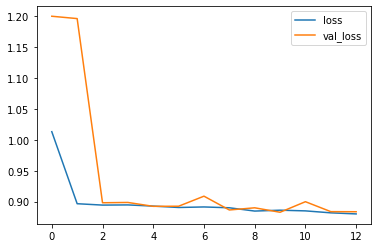

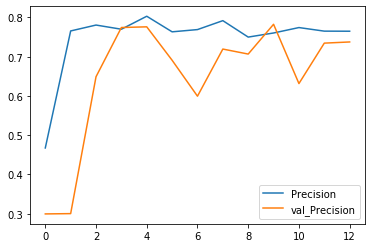

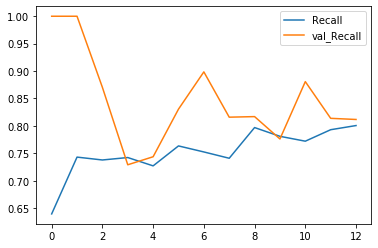

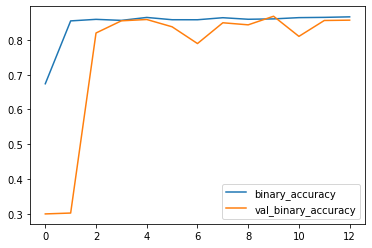

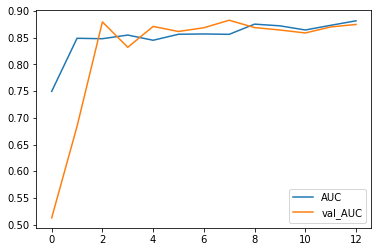

In [32]:
dh = pd.DataFrame(data=order_model.history.history)
dh
dh[['loss','val_loss']].plot()
dh[['Precision','val_Precision']].plot()
dh[['Recall','val_Recall']].plot()
dh[['binary_accuracy', 'val_binary_accuracy']].plot()
dh[['AUC','val_AUC']].plot()

#### Display classification and confusion matrices

In [33]:
# Performance on the validation set

predicted = order_model.predict(X_val)
predictions = np.rint(predicted)
print('Training Set Confusion Matrix')
print(confusion_matrix(y_val,predictions))
print('Training Set Classification Report')
print(classification_report(y_val,predictions))

Training Set Confusion Matrix
[[1933  304]
 [ 176  780]]
Training Set Classification Report
              precision    recall  f1-score   support

           0       0.92      0.86      0.89      2237
           1       0.72      0.82      0.76       956

    accuracy                           0.85      3193
   macro avg       0.82      0.84      0.83      3193
weighted avg       0.86      0.85      0.85      3193



In [34]:
# Performance on the Test set

predicted = order_model.predict(X_test)
predictions = np.rint(predicted)
print('Test Set Confusion Matrix')
print(confusion_matrix(y_test,predictions))
print('Test Set Classification Report')
print(classification_report(y_test,predictions))

Test Set Confusion Matrix
[[512  77]
 [ 37 215]]
Test Set Classification Report
              precision    recall  f1-score   support

           0       0.93      0.87      0.90       589
           1       0.74      0.85      0.79       252

    accuracy                           0.86       841
   macro avg       0.83      0.86      0.85       841
weighted avg       0.87      0.86      0.87       841



In [35]:
filepath = 'win_val_model'
save_model(order_model, filepath, overwrite=True, include_optimizer=True, save_format=None,
    signatures=None, options=None)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: win_val_model/assets


### The important comparison is between the training set and the test set.  Both the confusion matrix and the classification report are nearly identical for both data sets meaning that the model will generalize to new data well.

In [36]:
from tensorflow.keras.backend import clear_session
clear_session()

In [37]:
# Train the predictor using all of the data set except the reserved test set for final evaluation

# set the number of epochs from validation set model using early stopping

e = dh.val_loss.min()
e = dh.index[dh['val_loss']== e]
epochs = e[0]

# initiate callbacks

es = EarlyStopping(monitor='loss', patience=5, verbose=0,
    mode='auto', min_delta=.005, restore_best_weights=True)

rlr = ReduceLROnPlateau(monitor='loss', factor=0.9,
                              mode = 'min', min_delta=.005, patience=2, min_lr=0.0001)

mckp = ModelCheckpoint(filepath='win_all_checkpoint', monitor='loss', verbose=0, save_best_only=True,
    save_weights_only=False, mode='auto', save_freq='epoch')


In [38]:
# Train model on merged train and validation set with epochs limited to the min loss epoch on validation set
# when order_model is fit the second time, even with changed data, it loads the final weights from the first fit automatically
# clear_session does not reset the weights in the model and the learning rate starts at the last rlr learning rate
# 

order_model.fit(X_all,y_all,
            batch_size=64,
            epochs=epochs,
            verbose=True,
            validation_data = None, class_weight=class_weight,
            callbacks=[es,rlr])

Train on 15964 samples
Epoch 1/9
15964/15964 [==============================] - 41s 3ms/sample - loss: 0.8884 - binary_accuracy: 0.8584 - Precision: 0.7564 - Recall: 0.7773 - AUC: 0.8679
Epoch 2/9
15964/15964 [==============================] - 58s 4ms/sample - loss: 0.8888 - binary_accuracy: 0.8632 - Precision: 0.7805 - Recall: 0.7553 - AUC: 0.8569
Epoch 3/9
15964/15964 [==============================] - 55s 3ms/sample - loss: 0.8847 - binary_accuracy: 0.8639 - Precision: 0.7731 - Recall: 0.7721 - AUC: 0.8757
Epoch 4/9
15964/15964 [==============================] - 55s 3ms/sample - loss: 0.8819 - binary_accuracy: 0.8606 - Precision: 0.7470 - Recall: 0.8079 - AUC: 0.8861
Epoch 5/9
15964/15964 [==============================] - 55s 3ms/sample - loss: 0.8827 - binary_accuracy: 0.8613 - Precision: 0.7525 - Recall: 0.7997 - AUC: 0.8743
Epoch 6/9
15964/15964 [==============================] - 53s 3ms/sample - loss: 0.8804 - binary_accuracy: 0.8644 - Precision: 0.7580 - Recall: 0.8033 - AUC: 

In [39]:
# Save model for prediction

filepath = 'win_all_model'
save_model(order_model, filepath, overwrite=True, include_optimizer=True, save_format=None,
    signatures=None, options=None)

INFO:tensorflow:Assets written to: win_all_model/assets


#### Display convergence

,loss,binary_accuracy,Precision,Recall,AUC,lr
0,0.888366,0.858431,0.756415,0.777313,0.867870,0.000900
1,0.888756,0.863192,0.780493,0.755337,0.856904,0.000900
2,0.884676,0.863944,0.773051,0.772080,0.875692,0.000900
3,0.881851,0.860624,0.747049,0.807869,0.886133,0.000810
4,0.882705,0.861313,0.752462,0.799707,0.874330,0.000810
5,0.880394,0.864382,0.758049,0.803265,0.877482,0.000810
6,0.879384,0.869018,0.774352,0.793638,0.875768,0.000729
7,0.877609,0.863067,0.743152,0.829008,0.879724,0.000729
8,0.877351,0.869456,0.770048,0.803893,0.876565,0.000656


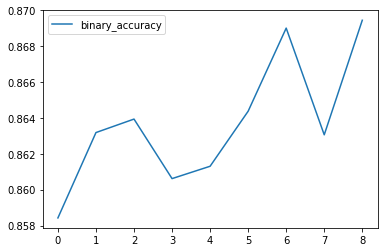

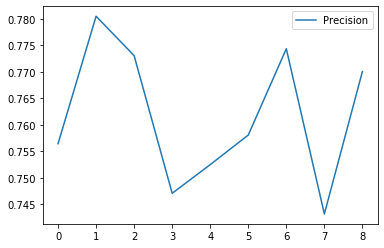

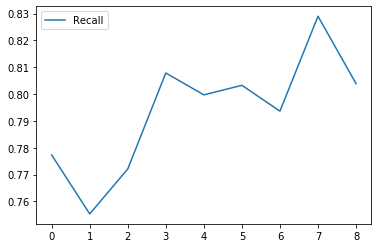

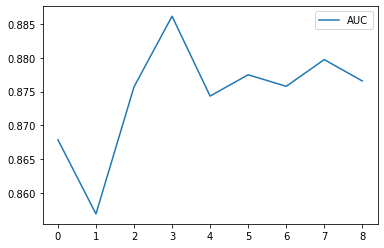

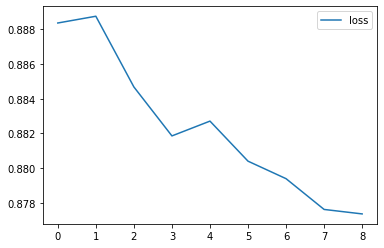

In [40]:
da = pd.DataFrame(data=order_model.history.history)
da
da[['binary_accuracy']].plot()
da[['Precision']].plot()
da[['Recall']].plot()
da[['AUC']].plot()
da[['loss']].plot()

#### Display confusion and classificaton matrices

In [41]:
# Display classification report and confusion matrix for fit on all data
predicted = order_model.predict(X_all)
predictions = np.rint(predicted)
print('Win All Confusion Matrix')
print(confusion_matrix(y_all,predictions))
print('Win All Classification Report')
print(classification_report(y_all,predictions))

Win All Confusion Matrix
[[9741 1445]
 [ 745 4033]]
Win All Classification Report
              precision    recall  f1-score   support

           0       0.93      0.87      0.90     11186
           1       0.74      0.84      0.79      4778

    accuracy                           0.86     15964
   macro avg       0.83      0.86      0.84     15964
weighted avg       0.87      0.86      0.87     15964



In [42]:
# Display classification report and confusion matrix from fit on all data for test data
predicted = order_model.predict(X_test)
predictions = np.rint(predicted)
print('Win Test Confusion Matrix')
print(confusion_matrix(y_test,predictions))
print('Win Test Classification Report')
print(classification_report(y_test,predictions))

Win Test Confusion Matrix
[[506  83]
 [ 37 215]]
Win Test Classification Report
              precision    recall  f1-score   support

           0       0.93      0.86      0.89       589
           1       0.72      0.85      0.78       252

    accuracy                           0.86       841
   macro avg       0.83      0.86      0.84       841
weighted avg       0.87      0.86      0.86       841



#### Compute lift on random test sample

In [46]:
from random import sample

# Take random sample of y_test targets
random_preds = sample(list(y_test),y_test.shape[0])

# Display random predictions Classification Report
# Classificaton is expected as the distribution of binary labels
print ('Random Test Sample')
print(classification_report(y_test,random_preds))

Random Test Sample
              precision    recall  f1-score   support

           0       0.72      0.72      0.72       589
           1       0.34      0.34      0.34       252

    accuracy                           0.60       841
   macro avg       0.53      0.53      0.53       841
weighted avg       0.60      0.60      0.60       841



In [44]:
# Construct actual state confusion matrix
actual0 = [(len(y_test) - y_test.sum()),0]
actual1 = [0,y_test.sum()]
actual = pd.DataFrame([actual0,actual1],columns=['Actual_Lost','Actual_Won'])

# Add Won Lost labels to rows
actual['Won/Lost'] = ['Lost','Won']
cols = ['Won/Lost','Actual_Lost','Actual_Won']
actual = actual.loc[:,cols]

# Construct random state confusion matrix
random_confusion = pd.DataFrame(confusion_matrix(y_test,random_preds))
random_confusion.columns = ['RanPred_Lost','RanPred_Won']

# Construct predicted state confusion matrix
pred_confusion = pd.DataFrame(confusion_matrix(y_test,predictions))
pred_confusion.columns = ['Pred_Lost','Pred_Won']

# Concatenate confusion matrices
lift = pd.concat([actual,random_confusion,pred_confusion],axis=1)

# Reorder columns
cols = 'Won/Lost', 'Actual_Lost','RanPred_Lost', 'Pred_Lost', 'Actual_Won', 'RanPred_Won', 'Pred_Won'
lift = lift.loc[:,cols]

# Calculate Lift
lift['Lift_Won'] = list(abs(lift.RanPred_Won - lift.Pred_Won))


# Calculate precision:  true_positives/true_positive+false_positive
lift['Precision'] = [(lift.Pred_Lost[0]/(lift.Pred_Lost[0] + lift.Pred_Lost[1])),
                     (lift.Pred_Won[1]/(lift.Pred_Won[1] + lift.Pred_Won[0]))]

# Calculate recall: true_positives/true_positives + false_negatives
lift['Recall'] = [(lift.Pred_Lost[0]/(lift.Pred_Lost[0] + lift.Pred_Won[0])),
                (lift.Pred_Won[1]/(lift.Pred_Won[1] + lift.Pred_Lost[1]))]

# Display Lift
lift


,Won/Lost,Actual_Lost,RanPred_Lost,Pred_Lost,Actual_Won,RanPred_Won,Pred_Won,Lift_Won,Precision,Recall
0,Lost,589,410,506,0,179,83,96,0.931860,0.859083
1,Won,0,179,37,252,73,215,142,0.721477,0.853175


In [45]:
from tensorflow.keras.backend import clear_session
clear_session()
del order_model
gc.collect()

168408